# Clustering Universities by Financial Return on Investment

This notebook explores clustering methods to group universities based on their financial return on investment (ROI) using data from the College Scorecard.

## 1. Setup & Data Loading

First, we import the necessary Python libraries for data analysis, machine learning, and visualization. We'll then load the College Scorecard dataset.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings


# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [4]:
try:
    file_path = '../data/raw/most-recent-cohorts-institution.csv'
    missing_values = ["PrivacySuppressed", "NULL", "PS"]
    df_raw = pd.read_csv(file_path, na_values=missing_values)
    print("Dataset loaded successfully.")
    print(f"Shape of the dataset: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}.")
    print("Please make sure the 'most-recent-cohorts-institution.csv' file is in the 'data/raw/' directory.")
    df_raw = pd.DataFrame() # Create empty dataframe to prevent further errors

# Display the first few rows to understand the structure
if not df_raw.empty:
    display(df_raw.head())

Dataset loaded successfully.
Shape of the dataset: (6429, 3306)


/var/folders/2q/nzhd0ryn6nz37r6nt56sq0dm0000gp/T/ipykernel_35757/2798358810.py:4: DtypeWarning: Columns (9,1729,1743,1909,1910,1911,1912,1913,2197,2198,2200,2201,2202,2203,2204,2206,2207,2208,2209,2210,2211,2212,2213,2215,2216,2217,2218,2219,2220,2221,2222,2251,2252,2253,2254,2255,2256,2257,2258,2278,2279,2280,2281,2282,2283,2284,2285,2296,2297,2298,2299,2300,2301,2302,2303,2305,2306,2307,2308,2309,2310,2311,2312,2314,2315,2316,2317,2318,2319,2320,2321,2350,2351,2352,2353,2354,2355,2356,2357,2712,2713,2715,2716,2717,2718,2719,2721,2722,2724,2725,2726,2727,2728,2767,2768,2769,2770,2771,2772,2773,2784,2785,2786,2787,2788,2789,2790,2791,2793,2794,2795,2796,2797,2798,2799,2800,2802,2803,2804,2805,2806,2807,2808,2809,2820,2821,2822,2823,2824,2825,2826,2827,2838,2839,2840,2841,2842,2843,2844,2845,2919,2920,2922,2923,2924,2925,2926,2928,2929,2931,2932,2933,2934,2935,2937,2938,2939,2940,2941,2942,2943,2944,2946,2947,2948,2949,2950,2951,2952,2953,3027,3029,3030,3031,3032,3033,3044,3045,3046,304

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,COUNT_WNE_MALE1_P11,GT_THRESHOLD_P11,MD_EARN_WNE_INC1_P11,MD_EARN_WNE_INC2_P11,MD_EARN_WNE_INC3_P11,MD_EARN_WNE_INDEP0_P11,MD_EARN_WNE_INDEP1_P11,MD_EARN_WNE_MALE0_P11,MD_EARN_WNE_MALE1_P11,SCORECARD_SECTOR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,777.0,0.6250,36650.0,41070.0,47016.0,38892.0,41738.0,38167.0,40250.0,4
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,1157.0,0.7588,47182.0,51896.0,54368.0,50488.0,51505.0,46559.0,59181.0,4
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,67.0,0.5986,35752.0,41007.0,NaN,NaN,38467.0,32654.0,49435.0,5
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,802.0,0.7810,51208.0,62219.0,62577.0,55920.0,60221.0,47787.0,67454.0,4
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,1049.0,0.5378,32844.0,36932.0,37966.0,34294.0,31797.0,32303.0,36964.0,4


## 2. Exploratory Data Analysis (EDA)

Before we start clustering, we need to understand the data. We'll look at the distribution of our key variables and their relationships.

Based on our project proposal, we're interested in cost, debt, and earnings.
Let's select these key features and give them more readable names.

- `COSTT4_A`: Average cost of attendance (academic year institutions)
- `DEBT_MDN`: The median original principal loan amount of all undergraduate borrowers of federal loans
- `MD_EARN_WNE_P8`: Median earnings of students working and not enrolled 8 years after entry
- `PREDDEG`: the type of award that the institution primarily confers
- `CONTROL`: Control of institution (1: Public, 2: Private nonprofit, 3: Private for-profit)
- `ADM_RATE`: Admission rate
- `C150_4`: Graduation rate (6 years after entry for first-time, full-time undergraduate students)
- `UGDS`: Total undergraduate enrollment

In [5]:
feature_map = {
    'INSTNM': 'InstitutionName',
    'COSTT4_A': 'AvgCost',
    'DEBT_MDN': 'MedianDebt',
    'MD_EARN_WNE_P8': 'MedianEarnings',
    'PREDDEG': 'PredominantDegree',
    'CONTROL': 'ControlType',
    'ADM_RATE': 'AdmissionRate',
    'C150_4': 'GraduationRate',
    'UGDS': 'UndergradEnrollment',
}

# Select only the columns we need
df_eda = df_raw[list(feature_map.keys())].copy()
df_eda.rename(columns=feature_map, inplace=True)

# Map numeric codes to degree names in 'PredominantDegree'
degree_map = {
    0: "Unclassified",
    1: "Certificate",
    2: "Associate's",
    3: "Bachelor's",
    4: "Graduate"
}
df_eda['PredominantDegree'] = df_eda['PredominantDegree'].map(degree_map)

control_map = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-profit"
}
df_eda['ControlType'] = df_eda['ControlType'].map(control_map)

# Count the unique values in the 'PredominantDegree' column
if not df_eda.empty:
    print("Counts of each unique value in 'PredominantDegree':")
    # Display value counts as a DataFrame for nicer formatting
    pred_deg_counts = df_eda['PredominantDegree'].value_counts(dropna=False).reset_index()
    pred_deg_counts.columns = ['PredominantDegree', 'Count']
    display(pred_deg_counts.style.hide(axis="index"))

# Filter for institutions with PredominantDegree == "Bachelors"
df_bachelors = df_eda[df_eda['PredominantDegree'] == "Bachelor's"]
print("\nFiltered DataFrame for Bachelor's degree institutions:")
display(df_bachelors.head())

if not df_bachelors.empty:

    print("\nCounts of each unique value in 'ControlType' with median enrollment:")
    # Display value counts as a DataFrame for nicer formatting
    control_counts = df_bachelors['ControlType'].value_counts(dropna=False).reset_index()
    control_counts.columns = ['ControlType', 'Count']

    # Display median undergraduate enrollment for each control type
    median_enrollment = df_bachelors.groupby('ControlType')['UndergradEnrollment'].median().reset_index()
    median_enrollment.columns = ['ControlType', 'MedianEnrollment']
    # Format Enrollment to one decimal place
    median_enrollment['MedianEnrollment'] = median_enrollment['MedianEnrollment'].map(lambda x: f"{x:.1f}")

    merged_control = pd.merge(control_counts, median_enrollment, on='ControlType', how='outer')
    display(merged_control.style.hide(axis="index"))
    

# Count rows with missing values in any of the key columns
# Create a table with a row for each feature and columns for count of missing and non-missing values
features = ['AvgCost', 'MedianDebt', 'MedianEarnings']
missing_table = pd.DataFrame({
    'Feature': features,
    'Non-missing Count': [df_bachelors[feat].notna().sum() for feat in features],
    'Missing Count': [df_bachelors[feat].isna().sum() for feat in features]
})
missing_table.set_index('Feature', inplace=True)
print("\nMissing Values Summary Table:")
display(missing_table)

# Show examples of Bachelors institutions missing data in key columns
df_bachelors.head()

print("\nSummary statistics of key features:")
# Display summary statistics with all decimals formatted to 2 decimal points
with pd.option_context('display.precision', 2):
    desc = df_bachelors.describe()
    desc.loc['count'] = desc.loc['count'].astype(int)
    display(desc.map(lambda x: f"{x:.2f}" if isinstance(x, float) else x))

Counts of each unique value in 'PredominantDegree':


PredominantDegree,Count
Certificate,2663
Bachelor's,1983
Associate's,996
Unclassified,507
Graduate,280



Filtered DataFrame for Bachelor's degree institutions:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,PredominantDegree,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment
0,Alabama A & M University,23751.0,16600.0,31992.0,Bachelor's,Public,0.6622,0.2874,5726.0
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Bachelor's,Public,0.8842,0.6260,12118.0
2,Amridge University,NaN,13385.0,34613.0,Bachelor's,Private Nonprofit,NaN,0.4000,226.0
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Bachelor's,Public,0.7425,0.6191,6650.0
4,Alabama State University,22028.0,17500.0,32520.0,Bachelor's,Public,0.9564,0.3018,3322.0



Counts of each unique value in 'ControlType' with median enrollment:


ControlType,Count,MedianEnrollment
Private For-profit,156,395.0
Private Nonprofit,1227,1068.5
Public,600,5492.0



Missing Values Summary Table:


,Non-missing Count,Missing Count
Feature,,
AvgCost,1797,186
MedianDebt,1825,158
MedianEarnings,1830,153



Summary statistics of key features:


,AvgCost,MedianDebt,MedianEarnings,AdmissionRate,GraduationRate,UndergradEnrollment
count,1797.00,1825.00,1830.00,1622.00,1839.00,1980.00
mean,39318.83,15968.47,51737.80,0.72,0.54,4394.38
std,18775.79,4453.53,16104.21,0.23,0.21,8842.81
min,6362.00,3500.00,15556.00,0.00,0.00,0.00
25%,23838.00,12861.00,41666.25,0.60,0.41,589.00
50%,34345.00,15722.00,49869.00,0.77,0.55,1502.50
75%,51879.00,19250.00,58598.00,0.90,0.68,4146.75
max,87804.00,38980.00,147923.00,1.00,1.00,156755.00


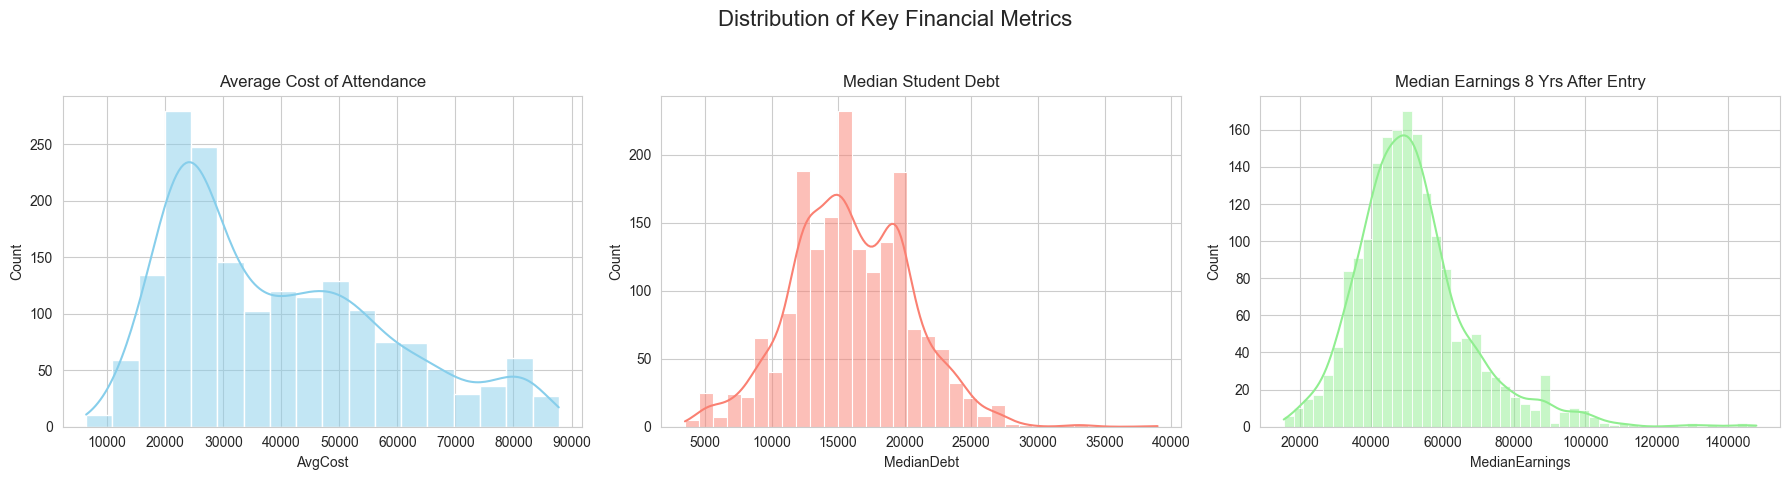


Pairwise relationships between features:


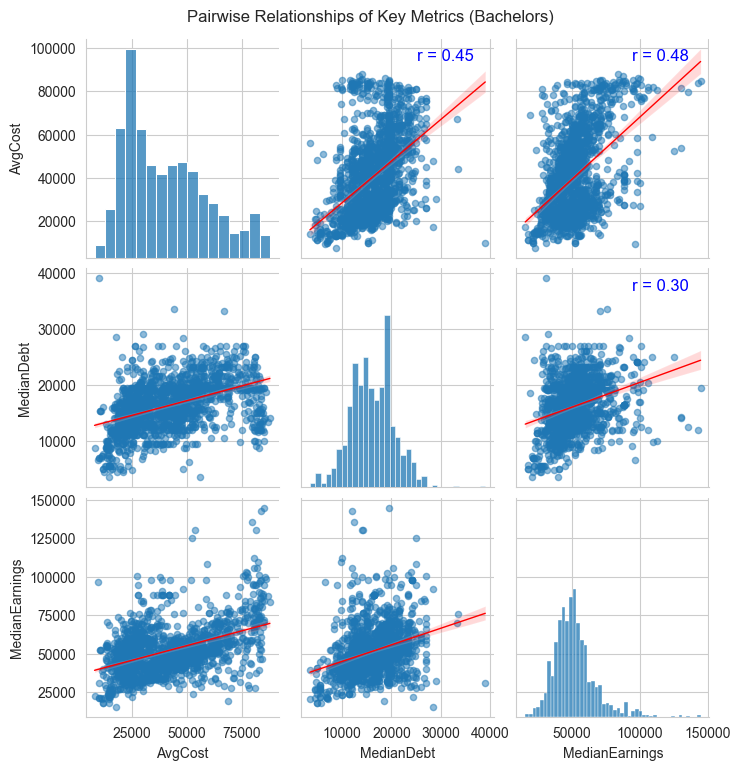

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Visualize the distributions of the key numerical features (for df_bachelors)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Distribution of Key Financial Metrics', fontsize=16)

    sns.histplot(df_bachelors['AvgCost'], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Average Cost of Attendance')

    sns.histplot(df_bachelors['MedianDebt'], kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Median Student Debt')

    sns.histplot(df_bachelors['MedianEarnings'], kde=True, ax=axes[2], color='lightgreen')
    axes[2].set_title('Median Earnings 8 Yrs After Entry')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Visualize the relationship between features using a pairplot (for df_bachelors)
    print("\nPairwise relationships between features:")

    # Calculate correlation matrix for the selected features
    corr = df_bachelors[['AvgCost', 'MedianDebt', 'MedianEarnings']].corr().round(2)

    # Annotated pairplot with correlation coefficients
    import itertools
    g = sns.pairplot(
        df_bachelors[['AvgCost', 'MedianDebt', 'MedianEarnings']].dropna(),
        kind='reg',
        plot_kws={'line_kws': {'color': 'red', 'lw': 1}, 'scatter_kws': {'alpha': 0.5, 's': 20}}
    )
    # Add correlation coefficients to the upper triangle
    for i, j in itertools.combinations(range(3), 2):
        ax = g.axes[i, j]
        feature_x = g.x_vars[j]
        feature_y = g.y_vars[i]
        r = corr.loc[feature_x, feature_y]
        ax.annotate(f"r = {r:.2f}", (0.6, 0.9), xycoords='axes fraction', fontsize=12, color='blue')

    plt.suptitle('Pairwise Relationships of Key Metrics (Bachelors)', y=1.02)
    plt.show()

## 3. Feature Selection & Preprocessing

Now, we prepare the data for the clustering algorithm. This involves:
1. Selecting our final features for clustering.
2. Converting columns to numeric types, forcing errors.
3. Handling missing values.
4. Scaling the features so they are on a comparable scale.

In [7]:
df_processed = df_bachelors.dropna(subset=['AvgCost', 'MedianDebt', 'MedianEarnings']).copy()
df_processed.drop(columns=['PredominantDegree'], inplace=True)

print(f"Original number of institutions: {len(df_bachelors)}")
print(f"Number of institutions after dropping missing values: {len(df_processed)}")
print(f"Percentage of data kept: {len(df_processed) / len(df_bachelors) * 100:.2f}%")

# Select the final features for clustering
features_for_clustering = ['AvgCost', 'MedianDebt', 'MedianEarnings']
X = df_processed[features_for_clustering]

# Standardize the features
# K-Means is distance-based, so it's crucial that all features are on the same scale.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData has been preprocessed and is ready for clustering.")
print(f"Shape of scaled data: {X_scaled.shape}")


Original number of institutions: 1983
Number of institutions after dropping missing values: 1671
Percentage of data kept: 84.27%

Data has been preprocessed and is ready for clustering.
Shape of scaled data: (1671, 3)


## 4. K-Means Clustering & Model Selection

We will now apply the K-Means algorithm. A key part of using K-Means is choosing the right number of clusters (`k`). We'll use the Silhouette Score to help us make this decision.

We'll test a range of k values and calculate the silhouette score for each.
A higher silhouette score indicates better-defined clusters.

For k=2, Silhouette Score: 0.3671, Inertia: 3028.64
For k=3, Silhouette Score: 0.3327, Inertia: 2358.49
For k=4, Silhouette Score: 0.3036, Inertia: 2157.87
For k=5, Silhouette Score: 0.2619, Inertia: 1769.48
For k=6, Silhouette Score: 0.2451, Inertia: 1645.19
For k=7, Silhouette Score: 0.2865, Inertia: 1445.94
For k=8, Silhouette Score: 0.2815, Inertia: 1292.30
For k=9, Silhouette Score: 0.2796, Inertia: 1214.86
For k=10, Silhouette Score: 0.2644, Inertia: 1107.17
For k=11, Silhouette Score: 0.2735, Inertia: 1026.47
For k=12, Silhouette Score: 0.2745, Inertia: 965.40
For k=13, Silhouette Score: 0.2766, Inertia: 907.67
For k=14, Silhouette Score: 0.2741, Inertia: 869.08
For k=15, Silhouette Score: 0.2767, Inertia: 829.32


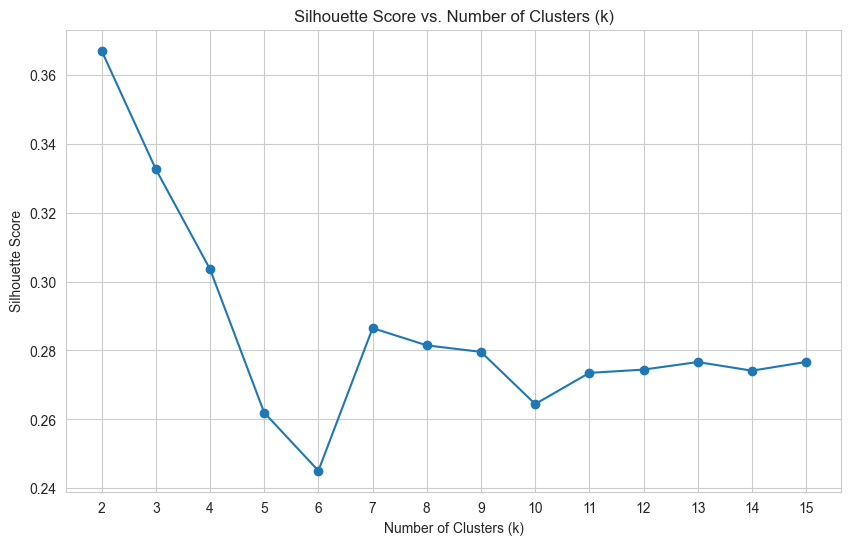


Based on the silhouette score, the optimal number of clusters is: 2

We will proceed with k=4 to provide more meaningful groupings.


In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    k_range = range(2, 16) # Test k from 2 to 15
    silhouette_scores = []
    inertia_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        
        # Calculate silhouette score
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        
        # Also store inertia (sum of squared distances to closest centroid)
        inertia_scores.append(kmeans.inertia_)
        print(f"For k={k}, Silhouette Score: {score:.4f}, Inertia: {kmeans.inertia_:.2f}")

    # Plot the Silhouette Scores to find the optimal k
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score vs. Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    # The "best" k is often the one with the highest silhouette score.
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nBased on the silhouette score, the optimal number of clusters is: {optimal_k}")
    chosen_k = 4
    print(f"\nWe will proceed with k={chosen_k} to provide more meaningful groupings.")


## 5. Cluster Analysis & Profiling

Now that we've chosen an `k`, we'll run K-Means one last time and analyze the resulting clusters.

Data with assigned clusters:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
0,Alabama A & M University,23751.0,16600.0,31992.0,Public,0.6622,0.2874,5726.0,0
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Public,0.8842,0.6260,12118.0,0
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Public,0.7425,0.6191,6650.0,0
4,Alabama State University,22028.0,17500.0,32520.0,Public,0.9564,0.3018,3322.0,0
5,The University of Alabama,32024.0,17986.0,56012.0,Public,0.7582,0.7369,32323.0,2



Cluster Profiles (mean values for each feature):


,AvgCost,MedianDebt,MedianEarnings,Count
Cluster,,,,
0,27090.80,12905.95,44668.08,789
1,63073.58,21380.19,71201.03,204
2,45573.06,18931.40,50252.84,604
3,78178.80,13902.82,83228.88,74


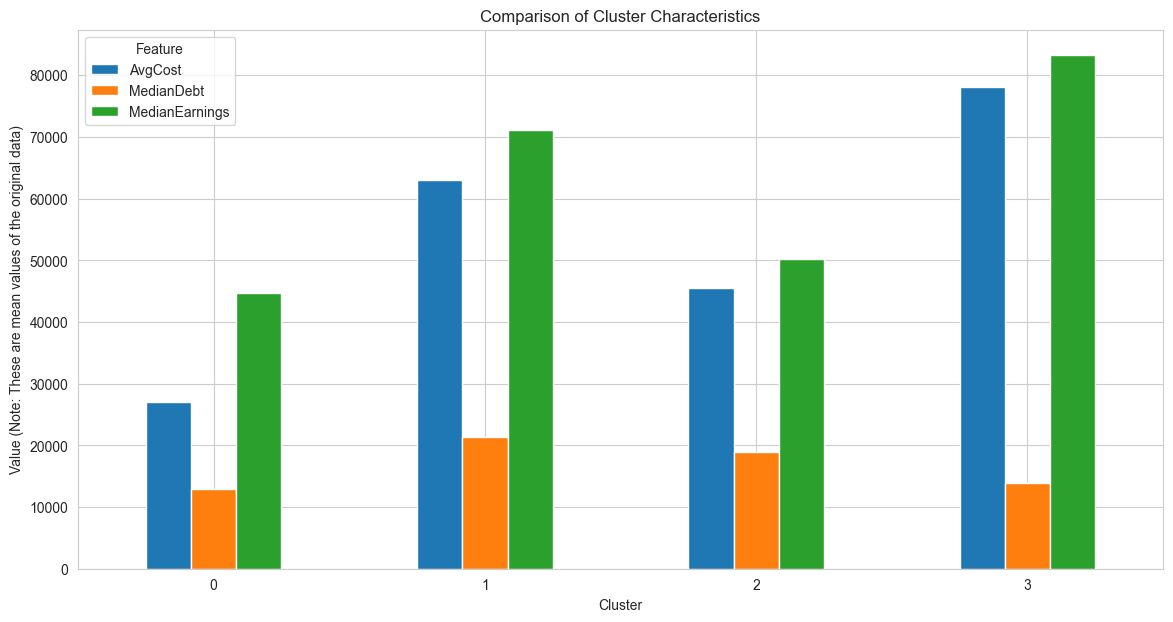


Pairplot colored by cluster label:


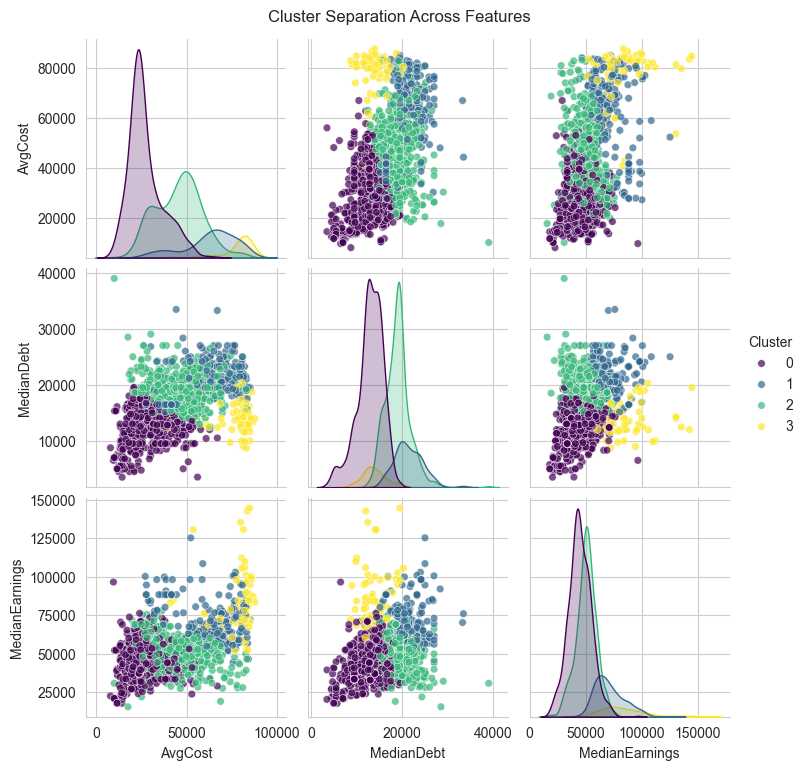

In [9]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Run K-Means with the optimal 
    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init='auto')
    df_processed['Cluster'] = kmeans_final.fit_predict(X_scaled)

    # Display the first few rows with their assigned cluster
    print("Data with assigned clusters:")
    display(df_processed.head())

    # Analyze the characteristics of each cluster by calculating the mean of our features.
    cluster_profile = df_processed.groupby('Cluster')[features_for_clustering].mean().round(2)

    # Also count the number of institutions in each cluster
    cluster_profile['Count'] = df_processed['Cluster'].value_counts()

    print("\nCluster Profiles (mean values for each feature):")
    display(cluster_profile)

    # Visualize the cluster profiles to easily compare them
    cluster_profile.drop('Count', axis=1).plot(kind='bar', figsize=(14, 7))
    plt.title('Comparison of Cluster Characteristics')
    plt.ylabel('Value (Note: These are mean values of the original data)')
    plt.xticks(rotation=0)
    plt.legend(title='Feature')
    plt.show()

    # Create a pairplot colored by cluster to see the separation in multi-dimensional space
    print("\nPairplot colored by cluster label:")
    sns.pairplot(df_processed, hue='Cluster', vars=features_for_clustering, palette='viridis', plot_kws={'alpha': 0.7, 's': 30})
    plt.suptitle('Cluster Separation Across Features', y=1.02)
    plt.show()

## 6. Conclusion & Interpretation

Based on the analysis, we have successfully segmented the universities into 4 distinct groups.

In [10]:
# Median admission and graduation rate, and count per cluster
cluster_medians = df_processed.groupby('Cluster')[['AvgCost', 'MedianDebt', 'MedianEarnings', 'AdmissionRate', 'GraduationRate', 'UndergradEnrollment']].median()
cluster_counts = df_processed['Cluster'].value_counts().sort_index()
cluster_medians['Count'] = cluster_counts

print("Median Admission and Graduation Rate, and Count per Cluster:")
display(cluster_medians)

# Percentage of each control type per cluster
control_type_pct = (
    df_processed.groupby('Cluster')['ControlType']
    .value_counts(normalize=True)
    .unstack(fill_value=0) * 100
).round(1)

print("\nPercentage of Each Control Type per Cluster:")
display(control_type_pct)
for cluster_label, group in df_processed.groupby('Cluster'):
    print(f"\nCluster {cluster_label}:")
    display(group.head())
    

Median Admission and Graduation Rate, and Count per Cluster:


,AvgCost,MedianDebt,MedianEarnings,AdmissionRate,GraduationRate,UndergradEnrollment,Count
Cluster,,,,,,,
0,24580.0,13000.0,44013.0,0.81105,0.46375,2573.0,789
1,65107.5,21100.0,68772.5,0.72560,0.75300,2417.0,204
2,46877.0,19000.0,50575.5,0.77800,0.59535,1347.0,604
3,81418.0,13572.0,79301.0,0.12965,0.91825,2957.5,74



Percentage of Each Control Type per Cluster:


ControlType,Private For-profit,Private Nonprofit,Public
Cluster,,,
0,7.6,36.9,55.5
1,10.8,82.4,6.9
2,2.3,79.3,18.4
3,0.0,98.6,1.4



Cluster 0:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
0,Alabama A & M University,23751.0,16600.0,31992.0,Public,0.6622,0.2874,5726.0,0
1,University of Alabama at Birmingham,27826.0,15832.0,51431.0,Public,0.8842,0.6260,12118.0,0
3,University of Alabama in Huntsville,27098.0,13905.0,61771.0,Public,0.7425,0.6191,6650.0,0
4,Alabama State University,22028.0,17500.0,32520.0,Public,0.9564,0.3018,3322.0,0
8,Auburn University at Montgomery,21873.0,13119.0,42659.0,Public,0.9263,0.3568,2693.0,0



Cluster 1:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
172,Art Center College of Design,71652.0,26000.0,58753.0,Private Nonprofit,0.7498,0.8261,2054.0,1
190,California Lutheran University,63768.0,18970.0,64258.0,Private Nonprofit,0.8888,0.7402,2374.0,1
191,California Polytechnic State University-San Lu...,29918.0,15396.0,82835.0,Public,0.2975,0.8519,21521.0,1
220,California State University Maritime Academy,27138.0,16889.0,100202.0,Public,0.9873,0.6682,761.0,1
236,Chapman University,81327.0,17750.0,67467.0,Private Nonprofit,0.5561,0.8036,7629.0,1



Cluster 2:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
5,The University of Alabama,32024.0,17986.0,56012.0,Public,0.7582,0.7369,32323.0,2
9,Auburn University,34402.0,17750.0,61406.0,Public,0.5047,0.7921,25732.0,2
10,Birmingham-Southern College,38385.0,16000.0,53677.0,Private Nonprofit,0.5194,0.6418,713.0,2
22,Huntingdon College,39686.0,20000.0,46532.0,Private Nonprofit,0.7083,0.4694,865.0,2
34,University of Mobile,38731.0,19000.0,41687.0,Private Nonprofit,0.7251,0.5551,1079.0,2



Cluster 3:


,InstitutionName,AvgCost,MedianDebt,MedianEarnings,ControlType,AdmissionRate,GraduationRate,UndergradEnrollment,Cluster
79,Embry-Riddle Aeronautical University-Prescott,60158.0,14250.0,76224.0,Private Nonprofit,0.7519,0.6976,3245.0,3
189,California Institute of Technology,83598.0,12000.0,142597.0,Private Nonprofit,0.0314,0.9316,1023.0,3
206,University of California-Berkeley,42708.0,12000.0,84865.0,Public,0.1166,0.9289,33073.0,3
245,Claremont McKenna College,82127.0,11948.0,105942.0,Private Nonprofit,0.1112,0.9517,1379.0,3
297,Harvey Mudd College,84896.0,19500.0,144598.0,Private Nonprofit,0.1306,0.9375,915.0,3
